### Filter Balance ###

In terms of survey strategy, "filter balance" refers to the distribution of visits between different filters (not considering any time dependency). The previous round of survey strategy evaluation (phase 1) found no strong obvious driver for changing the default filter balance for the low-dust WFD region, although mini-surveys do have different filter balance requests. 

One of the very basic implications of "Q1" is simply -- is it reasonable to use different filter balance distributions in different parts of the sky? This seems to be simple to approve, and in fact was already in place in previous baselines where the NES, for example, did not have any u or y band visits, and the SCP and GP were observed with different filter balances than the main portion of the WFD. It may be reasonable to state that the low-dust WFD will be observed with a single filter balance, the NES with a filter balance beneficial for SSOs, the SCP with another choice (that may be driven primarily by balancing visits among the few total # of visits), and then the galactic plane and bulge regions with more complicated filter balances chosen to optimize science in those regions (most likely based directly on a yet-to-be-finalized map coming from the TVS/SMWLV group). 


Beyond these basic aspects of changing filter balance in different parts of the sky, there were some questions about the filter balance in the general low-dust WFD. In particular, whether more time spent on bluer filters would be beneficial, primarily driven by Cadence Notes submitted for science studies of star forming galaxies, blue transients, and turn-off stars in the Milky Way. 

The v2.0 simulations include one family where the low-dust WFD region is skewed towards more blue (u and g) band visits. The filter balance isn't directly addressed in the longer u band visits family, but these and the 'good seeing' family are worth checking with similar metrics; these other families don't directly vary the number of visits in each bandpass, but longer u-band visits do have implications for visit depths and/or number of visits, and the typical visit depths can change as a result of changing the redistributing visits over different seeing bands.

One thing to note is that we do not have a photo-z 'metric' in MAF. However, there is a photo-z estimator that can be run on the median coadded depths. The code for this is here: https://github.com/dirac-institute/CMNN_Photoz_Estimator and an upcoming paper from Melissa Graham et al looks at some different coadded depth ratios (filter balances). Generally the paper sees that removing 5% of the time from u or g bands degrades photo-z for low redshift galaxies (z<0.6) and adding 5% of the time into u or g bands improves the photo-z for low-redshift galaxies .. the most dramatic improvement is adding the time into u band where the improvement could be as much as 5% in the robust standard deviation due to the improved depth in u band (g band is less improvement). Note that this looks like a change in the standard deviation of 0.012 to 0.011 in the photo-z determination for z<0.6. 

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [2]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summary_source = 'summary_2022_08_01.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_set = maf.get_metric_sets(metrics_source)

It may be helpful to show the region of the sky in question (the low-dust WFD) and then summarize some information about the current distribution of visits per band and their median depths, in each of these simulations. 
This is just presenting background information about the filter balance. 

In [3]:
opsdb = get_baseline()
runName = os.path.split(opsdb)[-1].replace('.db', '')

filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
m = maf.CountMetric(col='observationStartMJD', metricName='Nvisits', units='')
s = maf.HealpixSlicer(nside=64)
nvisits = {}
for f in filterlist:
    sql = f"filter = '{f}'"
    nvisits[f] = maf.MetricBundle(m, s, sql,
                                  runName=runName,
                                  info_label=f'{f}',
                                  plotDict={'percentileClip': 95})
g = maf.MetricBundleGroup(nvisits, opsdb, outDir='temp', verbose=False)
g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


0.0 180.0 -180.0 180.0


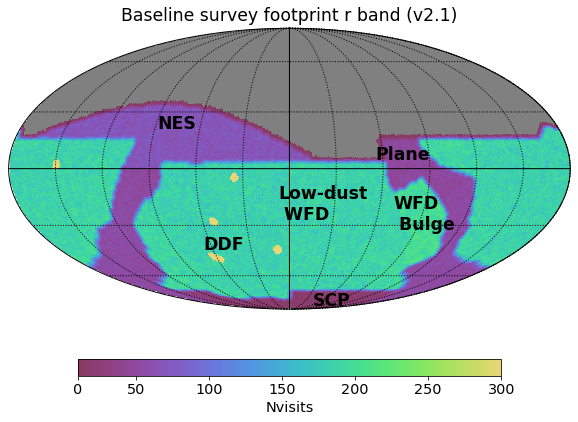

In [4]:
## Skymap with regions labelled
f = 'r' # bandpass
figformat = 'png'
ph = maf.PlotHandler(savefig=False, figformat=figformat, thumbnail=False, dpi=270, outDir='temp')
ph.setMetricBundles([nvisits[f]])
ph.plot(plotFunc=maf.plots.HealpixSkyMap(), 
        plotDicts={'colorMin': 10, 'colorMax':300, 'figsize': (8, 7),  'nTicks': 7,
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': "Nvisits"})
plt.figtext(0.49, 0.42, 'Low-dust\n WFD', fontsize='xx-large', fontweight='bold')
plt.figtext(0.28, 0.6, r'NES', fontsize='xx-large', fontweight='bold')
plt.figtext(0.69, 0.40, 'WFD\n Bulge', fontsize='xx-large', fontweight='bold')
plt.figtext(0.66, 0.54, r'Plane', fontsize='xx-large', fontweight='bold')
plt.figtext(0.55, 0.25, r'SCP', fontsize='xx-large', fontweight='bold')
plt.figtext(0.36, 0.36, r'DDF', fontsize='xx-large', fontweight='bold')
plt.title(f'Baseline survey footprint {f} band (v2.1)', fontsize='xx-large', fontweight='normal')
# We have to save the figure separately, because otherwise labels aren't getting saved.
plt.savefig(os.path.join('temp', f'{runName}_nvisits.{figformat}' ), 
            facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270, format=figformat)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


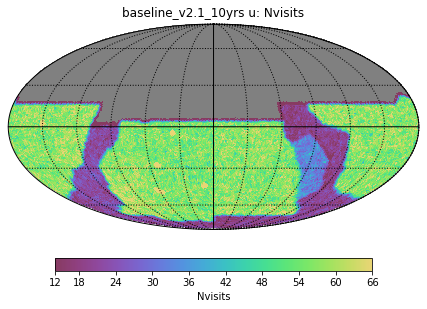

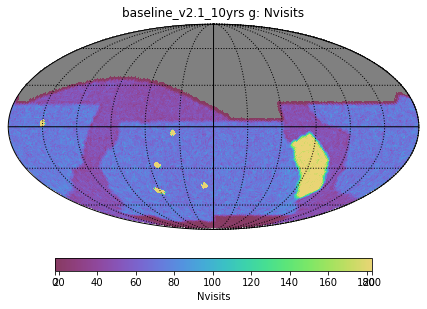

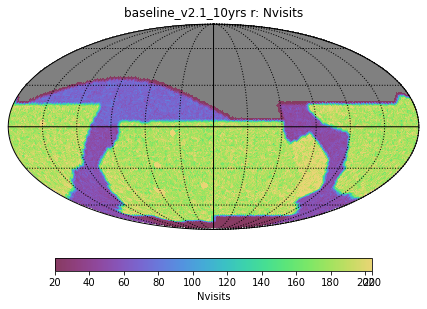

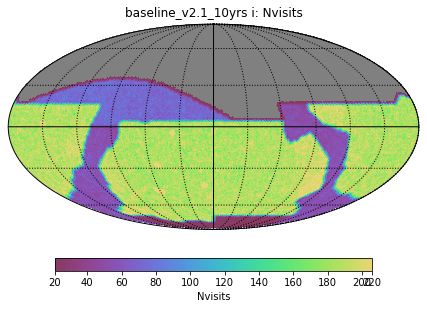

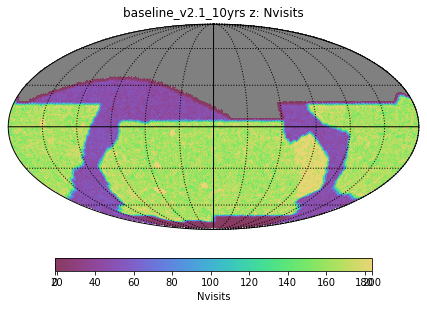

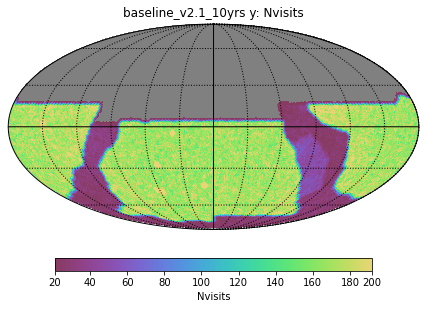

In [5]:
# Note some of the differences in different bandpasses - WFD Bulge is heavier in g, lighter in y for example,
# the background/dusty plane matches the WFD bulge balance, and the NES has no u or y band coverage
# (this is not the particular 'filter balance' in question here, but is useful to know)
ph = maf.PlotHandler()
for f in filterlist:
    ph.setMetricBundles([nvisits[f]])
    ph.plot(plotFunc=maf.HealpixSkyMap())

In [6]:
# Families that seem most relevant to check here
fam = ['bluer balance', 'longer u visits', 'good seeing', 'vary expt']
baseline_run = 'baseline_v2.0_10yrs'
these_runs = np.concatenate([[baseline_run], families.explode('run').loc[fam, 'run']])
lines = np.concatenate([[0],maf.find_family_lines(families, fam)[:-1],[11]]) + 1

In [7]:
maf.describe_families(families.loc[fam, :],
                        summary=summaries,
                        table_metric_set=metric_set.loc["short description"],
                        plot_metric_set=None,
                        baseline_run=baseline_run)

---
**bluer balance** : The standard filter balance in the dust-free WFD in the baseline is {'u': 0.07, 'g': 0.09, 'r': 0.22, 'i': 0.22, 'z': 0.20, 'y': 0.20}. These simulations vary the filter balance, skewing it bluer. One simulation adds visits to g band,while the other adds visits to both u and g band, in each case by taking some visits from rizy.  
**version**: 2.0  
**runs**:  


,brief,Area with >825 visits/pointing (fO_Area),Unextincted area i>25.9,Nvisits total,Median Nvis over top 18k (fO_Nv Med),Median Nvis u band,Median Nvis g band,Median Nvis r band,Median Nvis i band,Median Nvis z band,Median Nvis y band
run,,,,,,,,,,,
bluer_indx0_v2.0_10yrs,"More g - filter ratio in WFD of {'u': 0.07, 'g': 0.12, 'r': 0.21, 'i': 0.21, 'z': 0.19, 'y': 0.20}",12849.59,16155.56,2088051.0,839.0,53.0,94.0,170.0,171.0,152.0,166.0
bluer_indx1_v2.0_10yrs,"More u and g - filter ratio in WFD of {'u': 0.08, 'g': 0.11, 'r': 0.21, 'i': 0.21, 'z': 0.19, 'y': 0.20}",12876.44,16210.12,2089107.0,839.0,61.0,86.0,170.0,171.0,152.0,167.0


---
**longer u visits** : The baseline survey uses 2x15s visits for all bands except u band. In the baseline, u band visits are 1x30s to reduce the effects of readnoise (which are most extreme in u, due to the low sky-background). These simulations extend the u band visit time further, to 1x50s. In one simulation, the total amount of survey time spent on u band is kept the same, so the number of visits is reduced accordingly. In the other simulation, more survey time is spent in u band in order to maintain the number of visits in u.  
**version**: 2.0  
**runs**:  


,brief,Area with >825 visits/pointing (fO_Area),Unextincted area i>25.9,Nvisits total,Median Nvis over top 18k (fO_Nv Med),Median Nvis u band,Median Nvis g band,Median Nvis r band,Median Nvis i band,Median Nvis z band,Median Nvis y band
run,,,,,,,,,,,
long_u1_v2.0_10yrs,"u band visits 1x50s, number of u visits same as baseline",17197.97,16420.78,2021286.0,866.0,52.0,67.0,171.0,174.0,155.0,161.0
long_u2_v2.0_10yrs,"u band visits 1x50s, fewer number of u visits",15840.83,16687.68,2040731.0,854.0,33.0,70.0,177.0,181.0,160.0,167.0


---
**good seeing** : This family of simulations adds a requirement for 3 "good seeing" (seeing < 0.8 arcseconds) images per year, in various bandpasses. Note that `baseline_v2.1_10yrs` (and other v2.1 simulations) adds this requirement in r and i bands as the default.  
**version**: 2.1  
**runs**:  


,brief,Area with >825 visits/pointing (fO_Area),Unextincted area i>25.9,Nvisits total,Median Nvis over top 18k (fO_Nv Med),Median Nvis u band,Median Nvis g band,Median Nvis r band,Median Nvis i band,Median Nvis z band,Median Nvis y band
run,,,,,,,,,,,
good_seeing_gsw0.0_v2.1_10yrs,"Good seeing priority, with weight 0.0, grizy only",12814.34,16662.50,2083703.0,840.0,54.0,69.0,179.0,181.0,160.0,166.0
good_seeing_gsw1.0_v2.1_10yrs,"Good seeing priority, with weight 1.0, grizy only",12507.15,16831.19,2082749.0,839.0,54.0,69.0,179.0,181.0,160.0,166.0
good_seeing_gsw3.0_v2.1_10yrs,"Good seeing priority, with weight 3.0, grizy only",12434.14,16842.94,2081749.0,838.0,54.0,68.0,179.0,181.0,159.0,165.0
good_seeing_gsw6.0_v2.1_10yrs,"Good seeing priority, with weight 6.0, grizy only",12217.60,16857.21,2079596.0,837.0,54.0,69.0,179.0,182.0,158.0,165.0
good_seeing_gsw10.0_v2.1_10yrs,"Good seeing priority, with weight 10.0, grizy only",12151.29,16915.96,2078628.0,837.0,54.0,69.0,179.0,182.0,158.0,165.0
good_seeing_gsw20.0_v2.1_10yrs,"Good seeing priority, with weight 20.0, grizy only",11874.33,16857.21,2077820.0,836.0,53.0,68.0,179.0,182.0,158.0,165.0
good_seeing_gsw50.0_v2.1_10yrs,"Good seeing priority, with weight 50.0, grizy only",11885.24,16866.45,2077887.0,836.0,53.0,68.0,179.0,181.0,158.0,164.0
good_seeing_u_gsw0.0_v2.1_10yrs,"Good seeing priority, with weight 0.0, including ugri band",13287.70,16677.60,2087748.0,841.0,55.0,68.0,179.0,182.0,160.0,167.0
good_seeing_u_gsw1.0_v2.1_10yrs,"Good seeing priority, with weight 1.0, including ugri band",13242.38,16773.28,2087233.0,840.0,55.0,68.5,179.0,182.0,160.0,167.0


---
**vary expt** : The baseline survey strategy uses 2x15s visits for grizy filters, and 1x30s visits for u band. The simulations in this family vary the exposure time per visit from 20 to 40 seconds, to evaluate the impact on various metrics of varying individual image depth (the "shave_" runs). In addition, there is one simulation (`vary_expt_v2.0_10yrs`) which uses variable exposure time per visit to attempt to make the individual image depth consistent - each visit in this simulation could have an exposure time of between 20 to 100 seconds.  
**version**: --  
**runs**:  


,brief,Area with >825 visits/pointing (fO_Area),Unextincted area i>25.9,Nvisits total,Median Nvis over top 18k (fO_Nv Med),Median Nvis u band,Median Nvis g band,Median Nvis r band,Median Nvis i band,Median Nvis z band,Median Nvis y band
run,,,,,,,,,,,
shave_20_v2.1_10yrs,Reduce exposure time per visit to 20 seconds,19186.25,15422.02,2791414.0,1125.0,73.0,93.0,242.0,244.0,215.0,222.0
shave_22_v2.1_10yrs,Reduce exposure time per visit to 22 seconds,19074.63,15961.69,2611966.0,1053.0,68.0,87.0,226.0,228.0,200.0,208.0
shave_25_v2.1_10yrs,Reduce exposure time per visit to 25 seconds,18796.82,16501.35,2383592.0,961.0,62.0,79.0,206.0,208.0,183.0,189.0
shave_28_v2.1_10yrs,Reduce exposure time per visit to 29 seconds,18151.40,16810.21,2192248.0,884.0,57.0,72.0,189.0,191.0,168.0,174.0
shave_30_v2.1_10yrs,Keep exposure time per visit at 30 seconds,12524.78,17008.29,2081086.0,838.0,55.0,69.0,179.0,181.0,159.0,165.0
shave_32_v2.1_10yrs,Extend exposure time per visit to 32 seconds,2982.85,17111.52,1980338.0,797.0,51.0,65.0,170.0,172.0,151.0,157.0
shave_35_v2.1_10yrs,Extend exposure time per visit to 35 seconds,143.52,17180.34,1847269.0,744.0,48.0,61.0,158.0,161.0,141.0,147.0
shave_38_v2.1_10yrs,Extend exposure time per visit to 38 seconds,109.11,17224.82,1729706.0,696.0,45.0,57.0,148.0,150.0,131.0,138.0
shave_40_v2.1_10yrs,Extend exposure time per visit to 40 seconds,108.27,17265.95,1660675.0,667.0,43.0,55.0,142.0,144.0,126.0,131.0


(None, None)

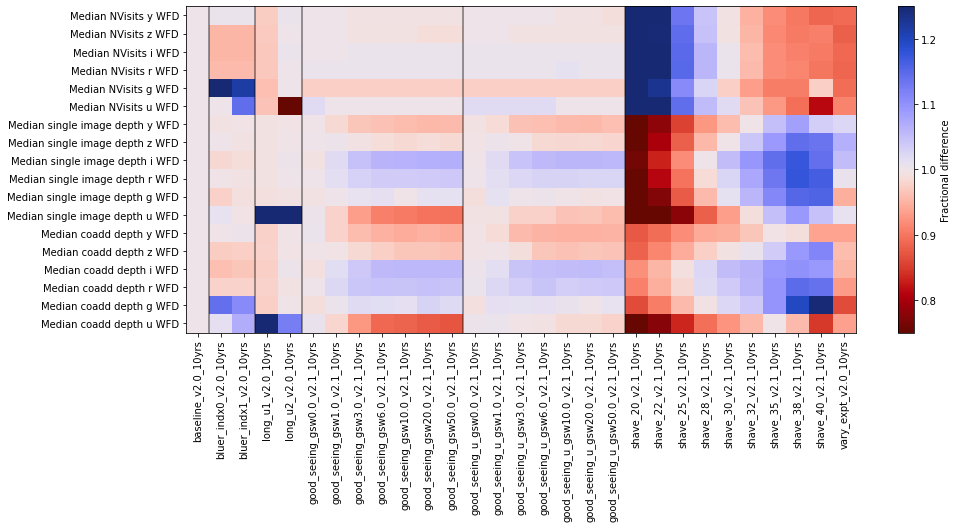

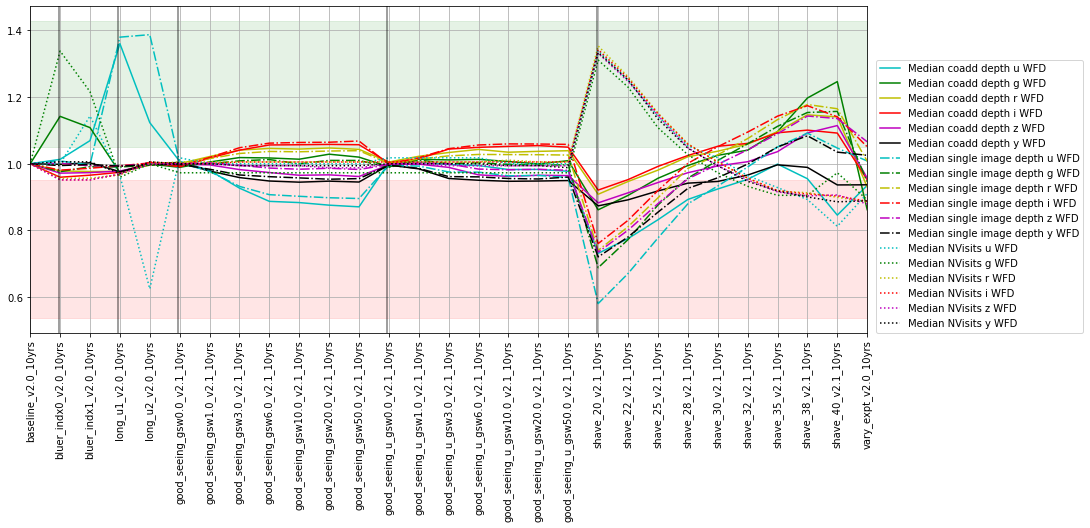

In [8]:
# So you can see the impact of changing the time distribution, on the depths. 
k = 'WFD Depths'

# Plot two versions of the figures
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_set.loc[k]['short_name'],
                                   metric_set=metric_set.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_set.loc[k],
                              metric_label_map=metric_set.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

The shifts you see above in the number of visits per band and the depths per image per band in the 'good seeing' series is why I think they are worth looking at here. The primary question does still revolve around the first two variations on the left of these plots (bluer_indx0 and bluer_indx1 from the 'bluer balance' family). 

I did look at these metrics across all of the other families of runs. Some of them are not really comparable -- adding microsurveys will throw off some of these metrics because they don't remove short visits, for example, and increasing the galactic plane footprint weight to the WFD-level makes it "count" as WFD, which changes the reported filter balance (but really this is only for part of the sky). The triplets family do change the image depths significantly, but this is due to the change in visit timing in the night, rather than truly due to changing how the visits are distributed between filters. The impact of the triplet and long gaps no pairs families are worth checking static science metrics against, but could be thought of as a separate question.

### Metrics ###

There are many considerations around the filter balance, but the primary drivers towards a bluer balance (from the previous Cadence Notes) were studies of star forming galaxies, turn-off stars and blue transients. 

We do have some transient metrics that should include blue transients (or at least that require blue band observations to identify the transient). We do not currently have metrics that specifically target identification of star forming galaxies, although we do have a metric looking at the expected total number of galaxies (in i band, but we can start running this in all bands). Similarly, I do not believe we have a metric looking at turn-off stars specifically, although we do have metrics that look at the overall number of stars. 

To reduce some of the confusion about the large numbers of metrics, I have chosen a subset here based on conversations with science collaborations and evaluating which metrics show the most variation across simulations. 


In [9]:
# List the metric sets so far (there are more metrics available though, but we have so far grouped them up this way)

msets = list(metric_set.groupby('metric set').first().index)
msets

for k in msets:
    print(k, len(metric_set.loc[k]))
    # Check that the metrics are correctly named and in the summary file
    summaries.loc[:, metric_set.loc[k]['metric']]

AGN N QSO 6
AGN SF 12
AGN SF DDF 36
AGN short 5
AGN timelag 12
DDF Cadence 48
DESC WFD 10
GP filters 12
GP footprint 6
GP season 6
GP visit 6
N Visits 9
SCOC 22
SL TDC 6
SRD 5
SSO N Objs 6
SSO discovery 14
SSO discovery options 22
SSO fraction 3 bands 14
SSO fraction 4 bands 14
SSO fraction 5 bands 14
SSO fraction 6 bands 14
SSO lightcurve inversion 8
Stars 9
TVS KNe 7
TVS KNe short 3
TVS PeriodModulation 8
TVS PeriodicDetect 6
TVS Presto 2
TVS TDE 5
TVS Tgaps 12
TVS XRB 3
TVS anomalies 5
TVS microlensing all 17
TVS microlensing short 4
TVS short 6
WFD Depths 18
cadence 8
galaxies 8
plot areas 5
radar 11
short description 10


In [10]:
[m for m in msets if 'short' in m or 'SCOC' in m 
 or ((m == 'DESC WFD') or (m == 'Stars') or (m == 'galaxies') or (m =='SRD') 
 or (m == 'SSO discovery') or (m=='SSO lightcurve inversion'))]

['AGN short',
 'DESC WFD',
 'SCOC',
 'SRD',
 'SSO discovery',
 'SSO lightcurve inversion',
 'Stars',
 'TVS KNe short',
 'TVS microlensing short',
 'TVS short',
 'galaxies',
 'short description']

['TVS KNe short', 'TVS microlensing short', 'TVS short']


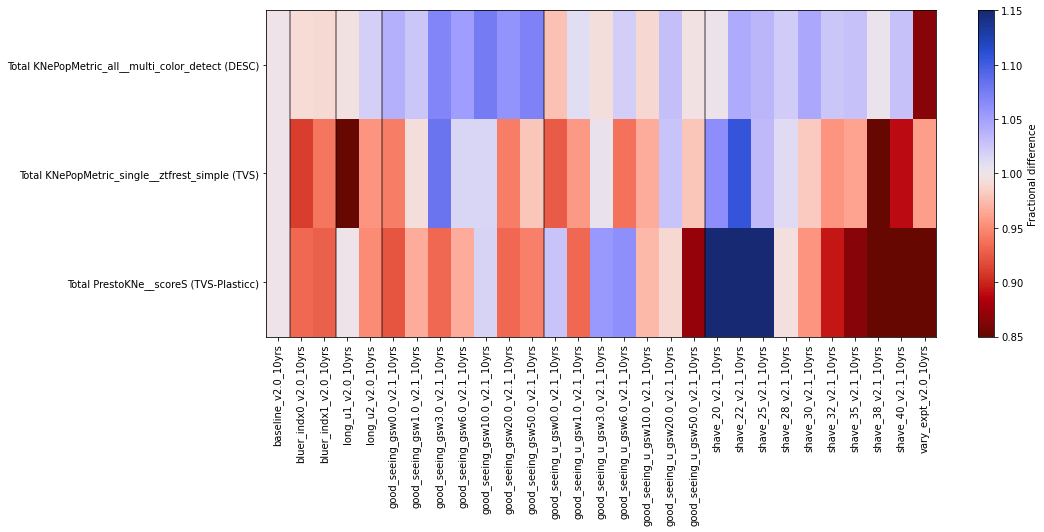

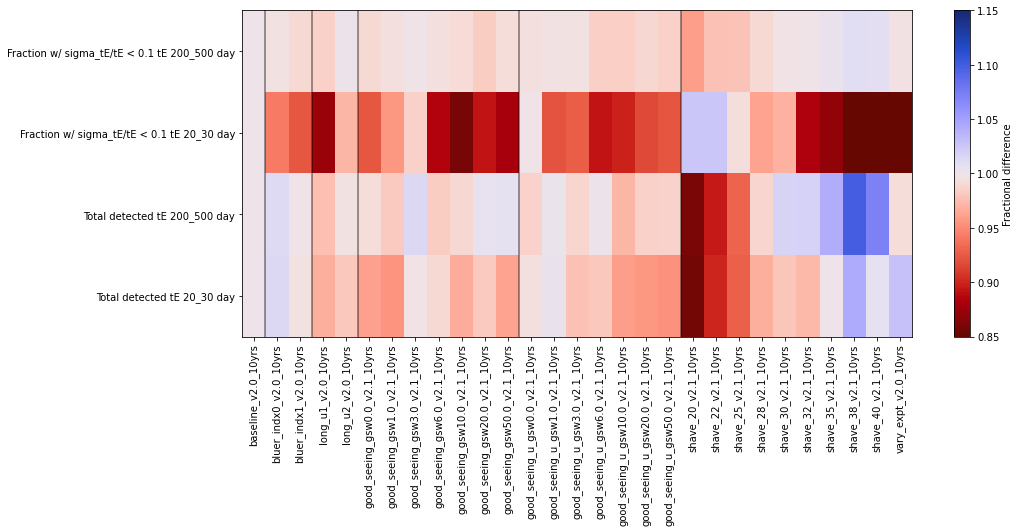

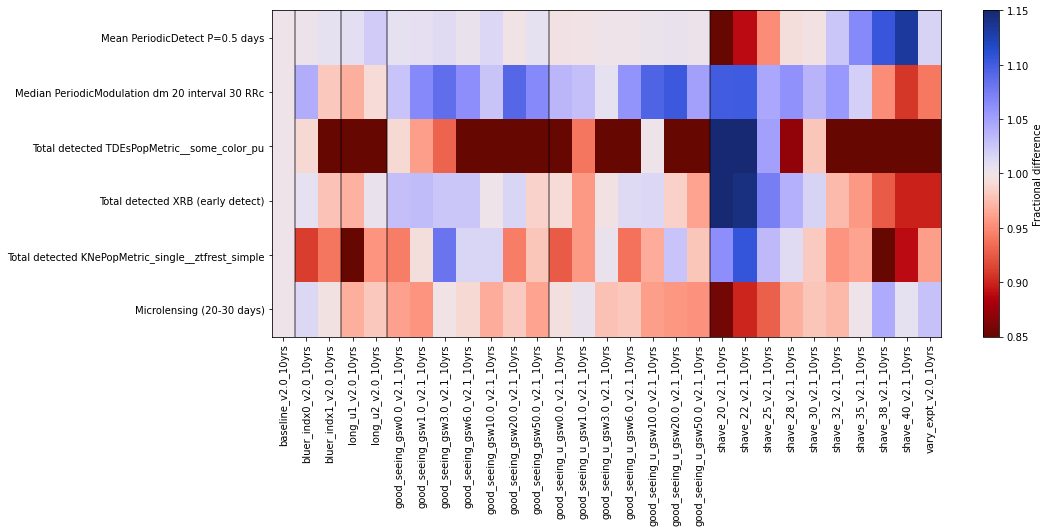

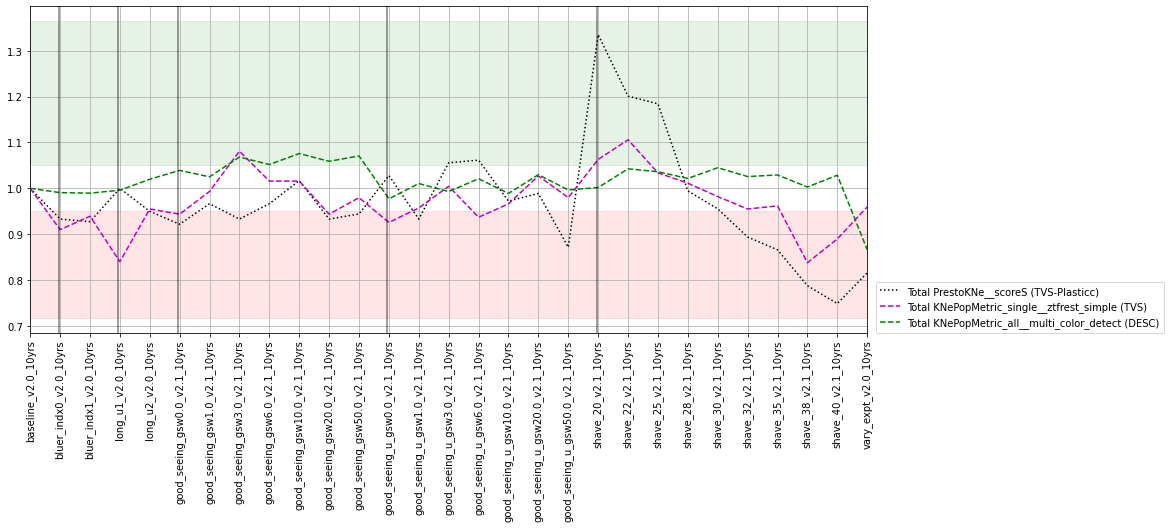

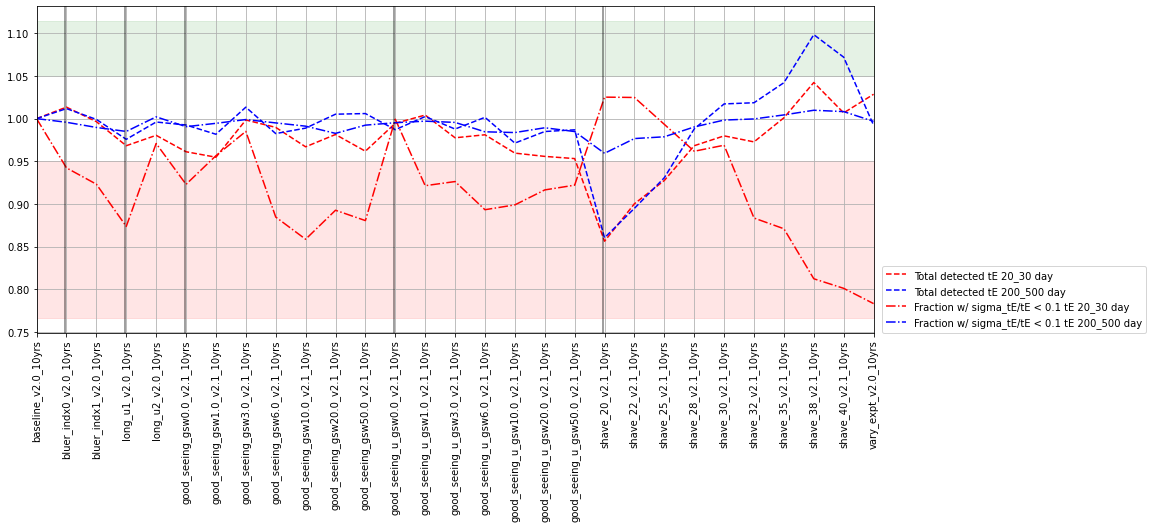

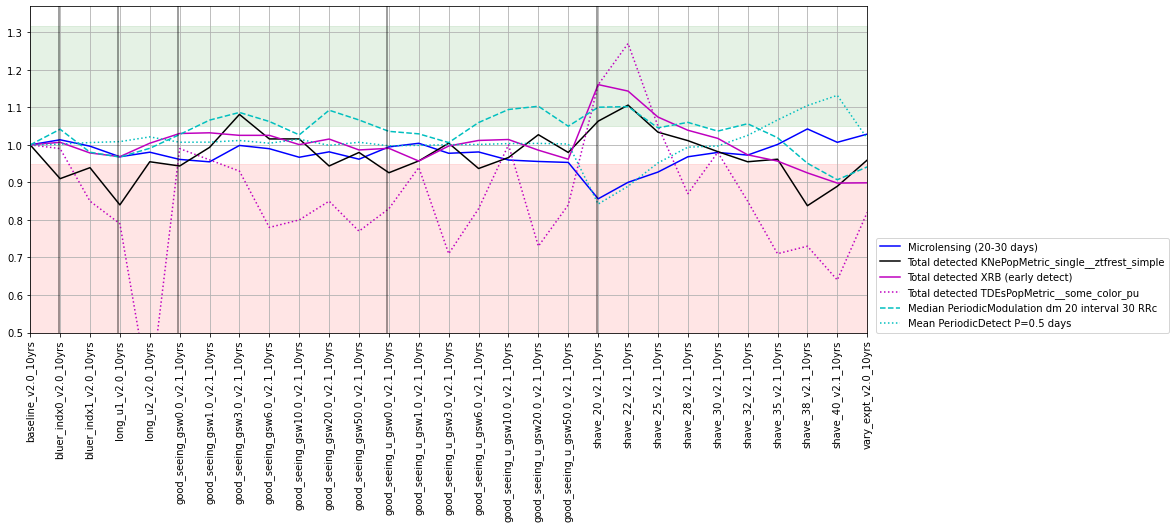

In [11]:
# Which metrics seem like the closest matches for our stated goals? 
# Primarily TVS fast transients - KNe, TDE, XRB
# The 'short' sets here are based on the preferred detection criteria from each group

kk = [k for k in msets if k.startswith('TVS') and 'short' in k]
print(kk)
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

My take here is that no TVS metrics strongly support shifting time into bluer bands. 
Moving time between 'good seeing' visits does improve some metrics, most likely due to the depths changing .. but whether or not this is an improvement depends on if depth moved into or out of the bands most important for detections. 

The TDE metric reflects a small fraction of objects which are detectable; the detection requirements are stringent. I believe this is why it appears more variable. My interpretation is that our knowledge of how these events will respond to real-life observations is likewise noisy (due to disruptions that will occur due to weather, etc.). TDE events are short-lived and the detection requirements include a color plus u band visits. 

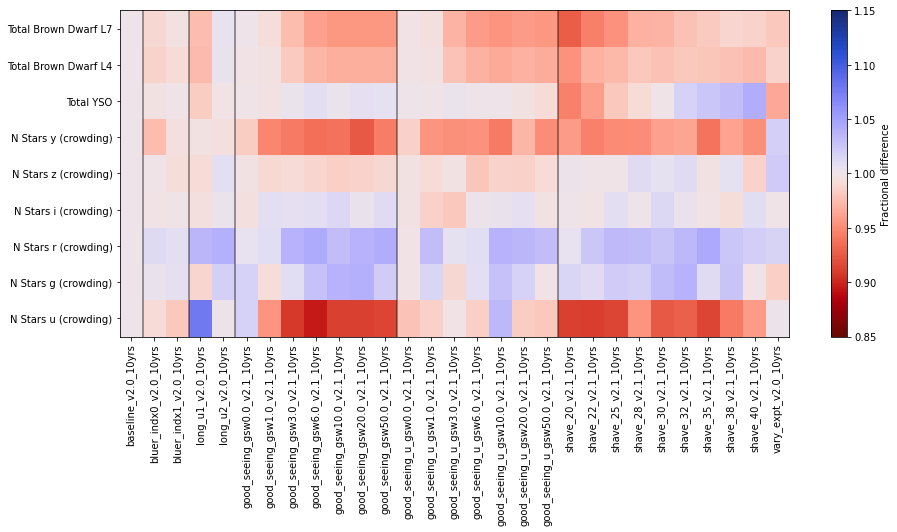

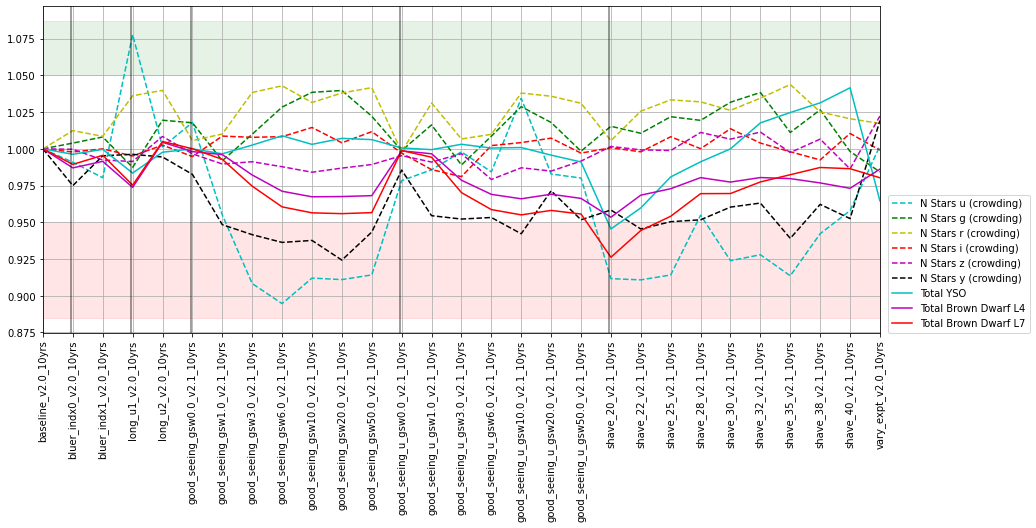

In [12]:
# Look for stellar populations
kk = [k for k in msets if k.startswith('Stars')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

We don't have a metric aimed at turn-off stars specifically. The metrics here tend to vary with the overall coadded depth, although because we're not varying the filter balance in the bulge WFD region, the effect is likely to be muted. 

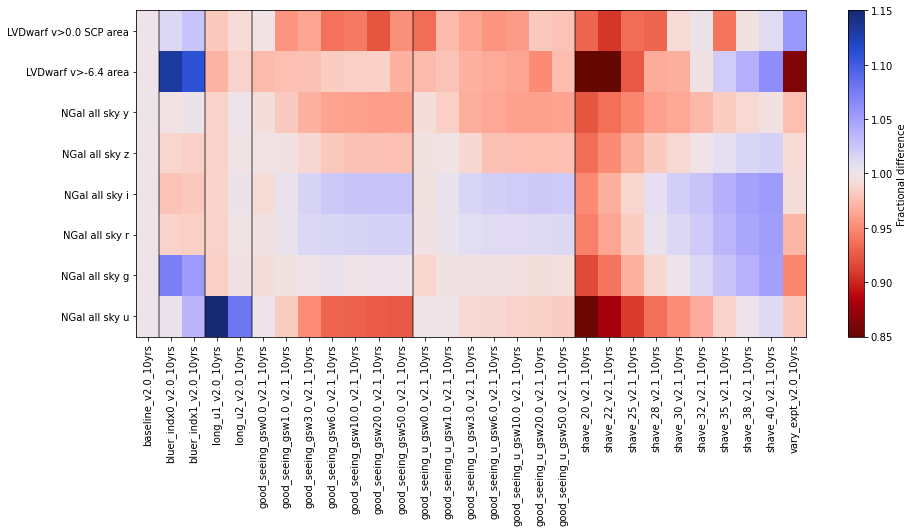

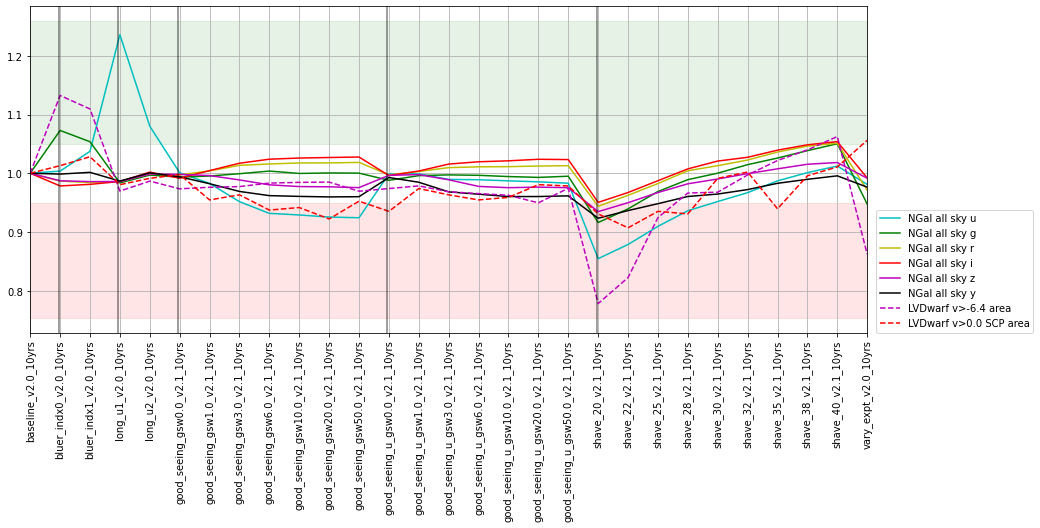

In [13]:
# Look at galaxies. (we only currently calculate galaxy counts in i band)
kk = [k for k in msets if k.startswith('galaxies')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

This is also more or less as expected, scaling with the coadded depth, but since we're looking at the number of galaxies in i band, adding more bluer visits doesn't help.

Other metrics:

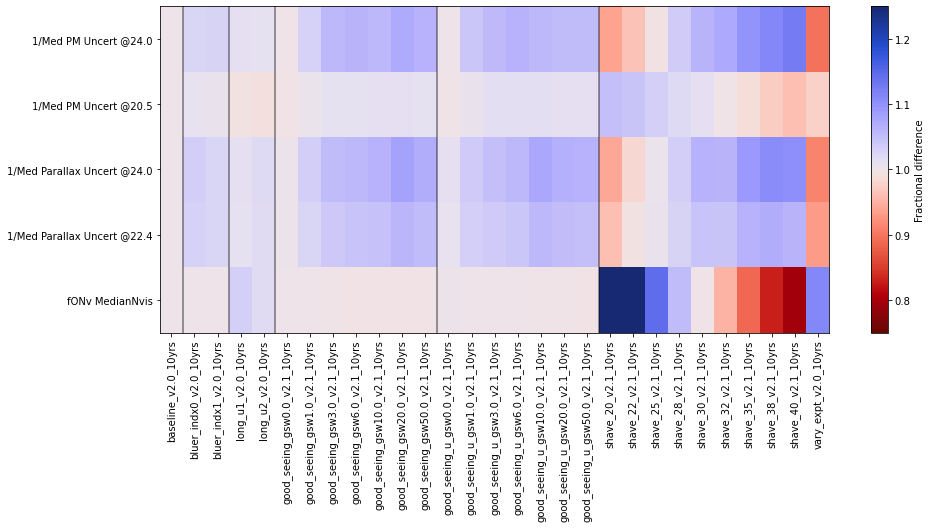

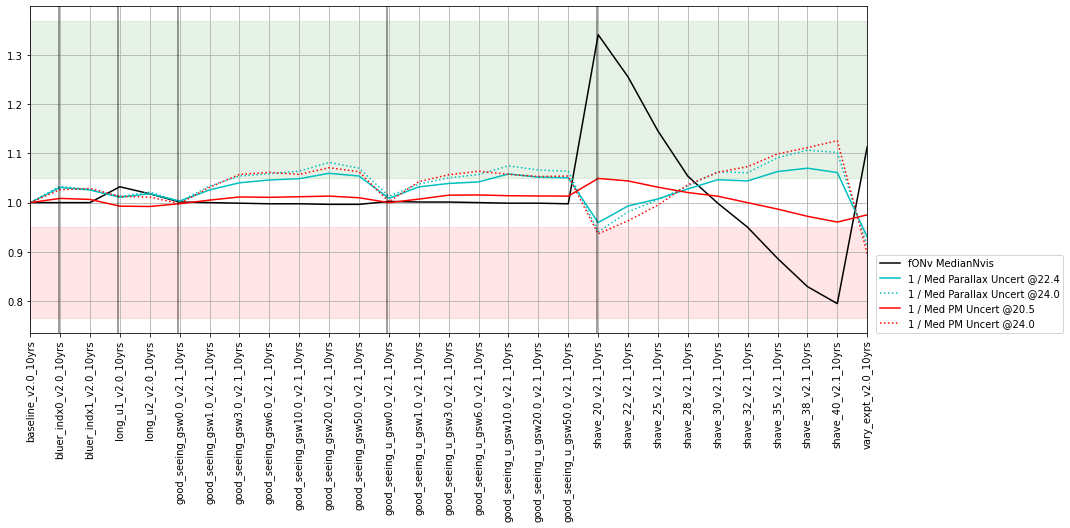

In [14]:
k = 'SRD'

# Plot two versions of the figures
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_set.loc[k]['short_name'],
                                   metric_set=metric_set.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_set.loc[k],
                              metric_label_map=metric_set.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

**SRD** Slightly surprising improvements in parallax and faint proper motion, which I believe is driven by more g band measurements in the bluer balance runs and slightly deeper per-image depths in g band in the good seeing runs. The longer u band visits is likely showing an improvement just due to having more visits overall (fONv Median Nvisits increases == more visits per pointing in the WFD).

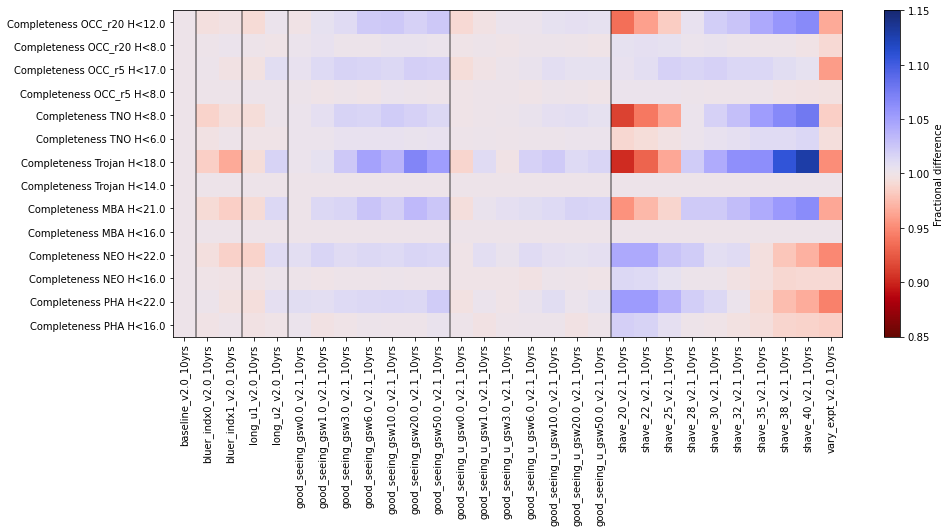

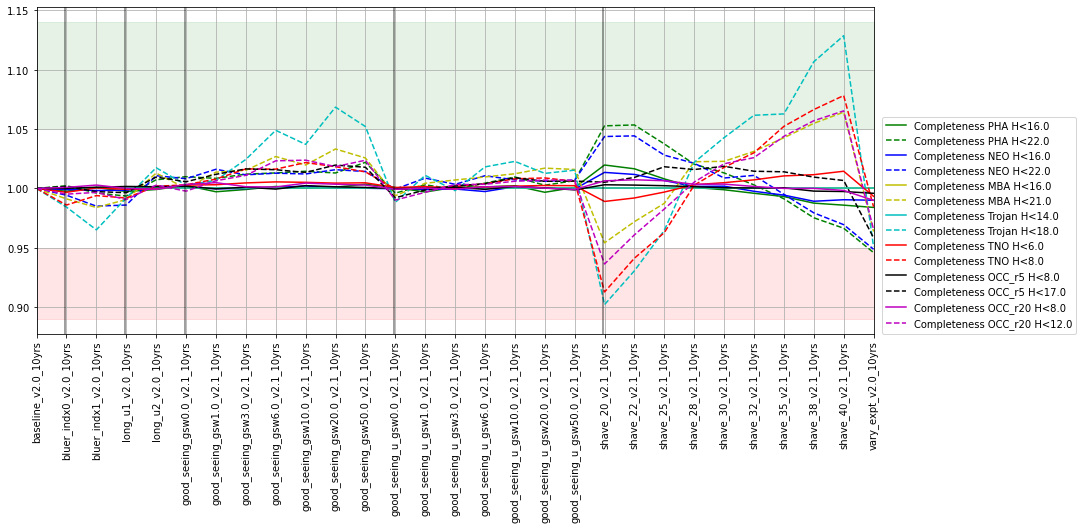

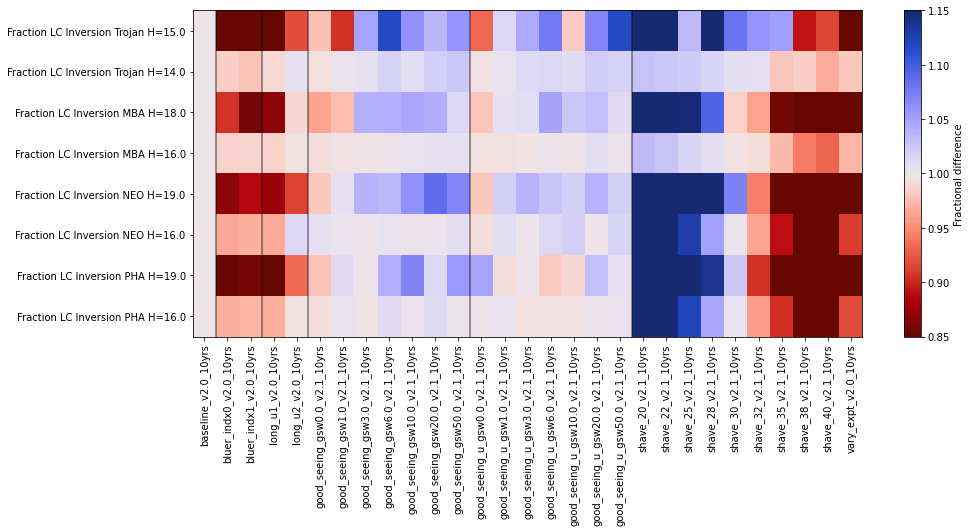

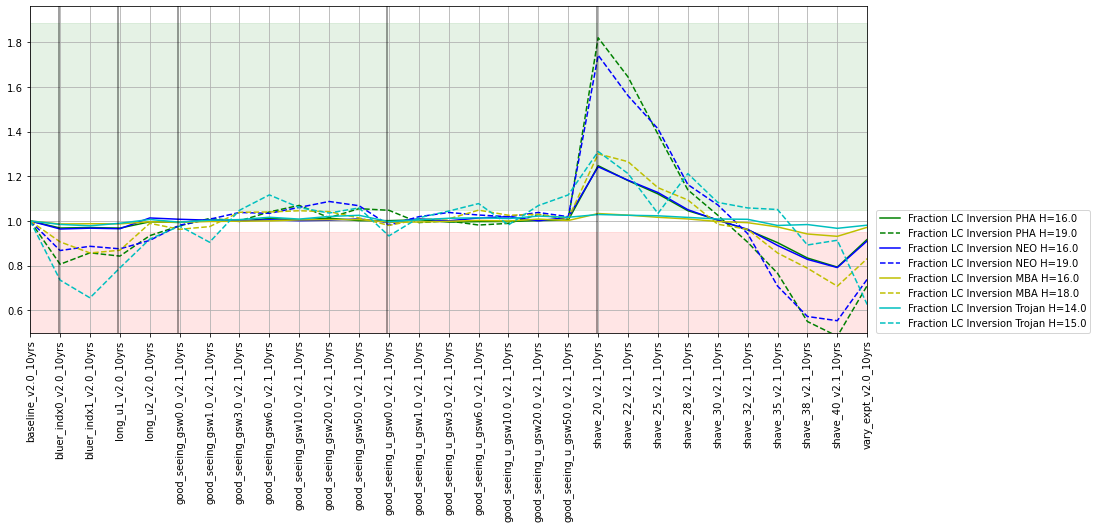

In [15]:
#  SSO metrics
for k in ['SSO discovery', 'SSO lightcurve inversion']:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

**SSO** The top-level solar system metrics (surrounding discovery completeness) are relatively neutral on the filter balance question, but more visits in u and g result in fewer faint objects that receive enough visits over a range of phases for successful lightcurve inversion (probably these objects needed visits in r and i bands, so fell just below threshold when those visits were shifted in g and/or u).   

As more weight is given to good seeing in gri bands, the lightcurve inversion improves, but adding u band returns these metrics to fairly neutral levels. 

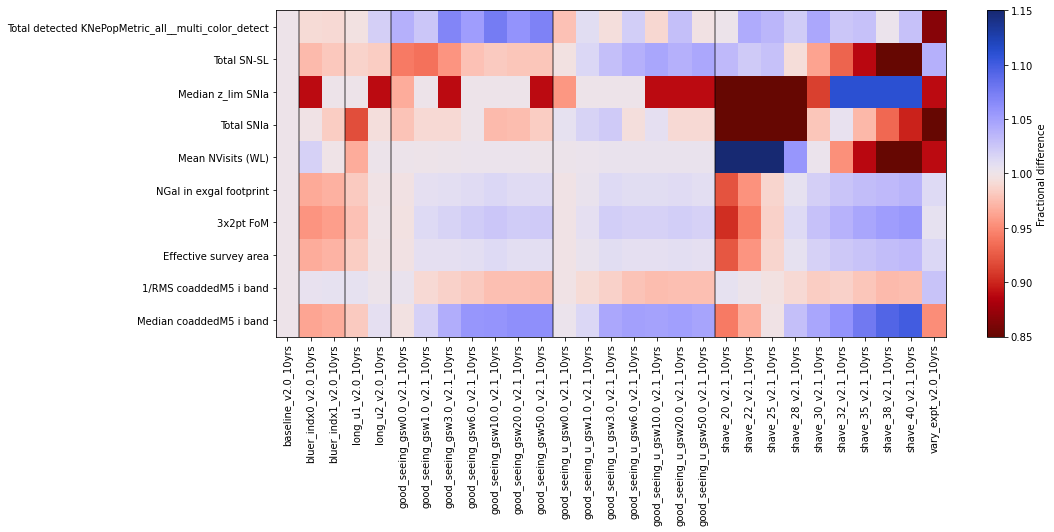

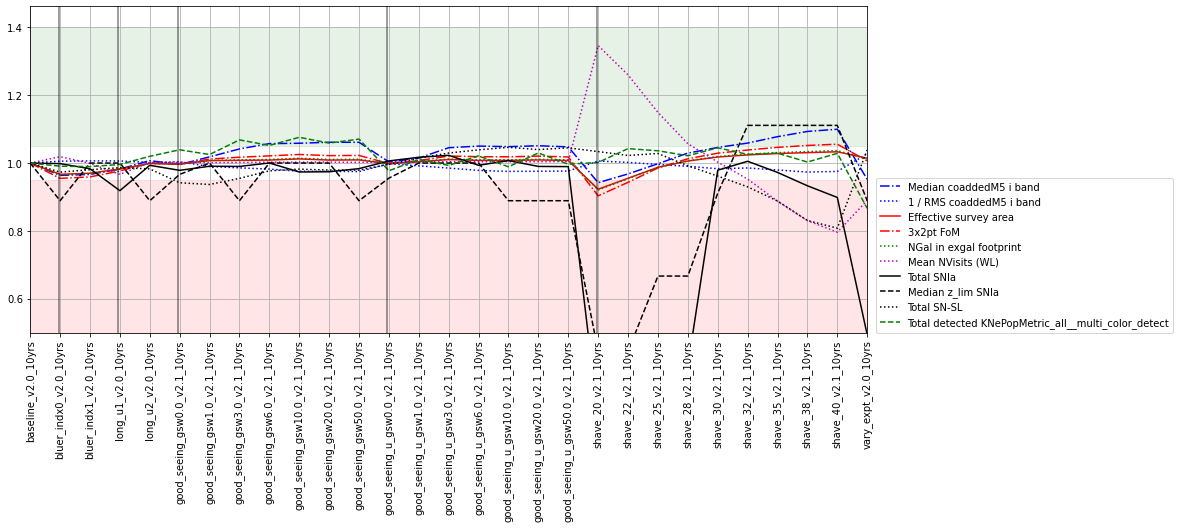

In [16]:
# Look at DESC 
kk = ['DESC WFD']
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

Most of the DESC metrics scale with the number of visits in redder bandpasses, so shifting time into bluer bands isn't a dramatic improvement. 
The photo-z standard deviation does improve for low-z galaxies, as stated above. 

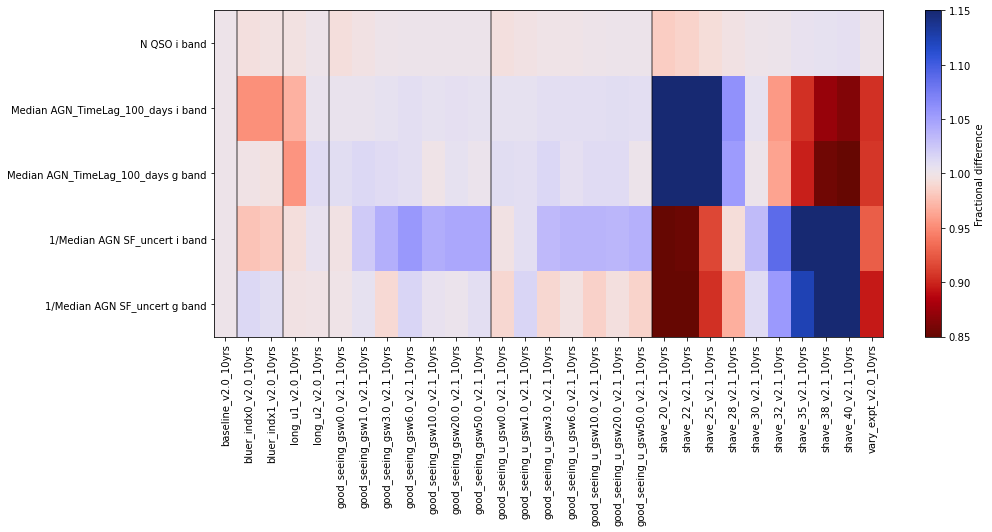

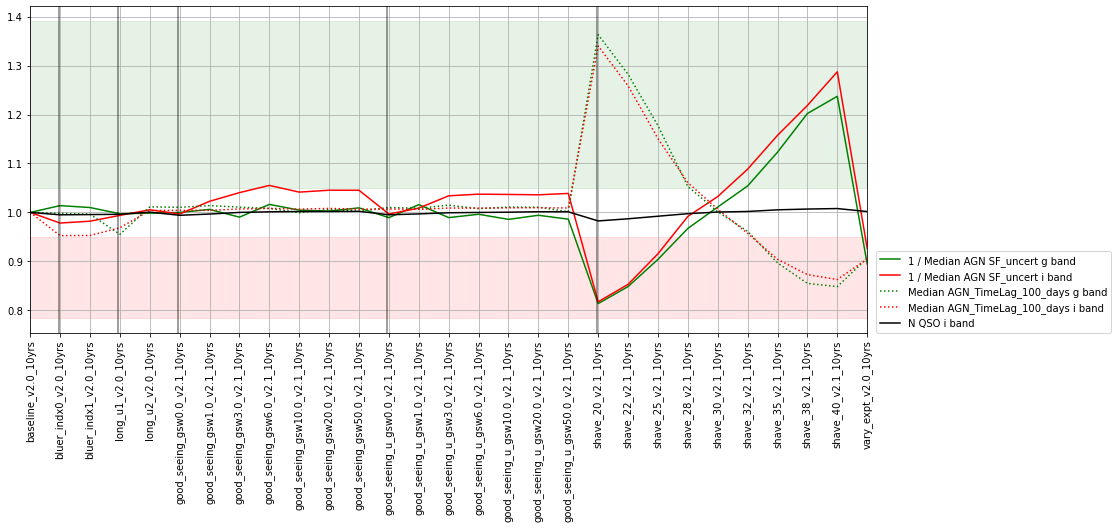

In [17]:
kk = ['AGN short']
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

Ok, so these AGN metrics are a subset of the total available metrics, and I don't know if they are the best options. Basically each metric (structure function uncertainty and time lags and number of QSO) is evaluated in each bandpass. More information from the AGN collaboration is needed to prioritize these, especially for the question of filter distribution.

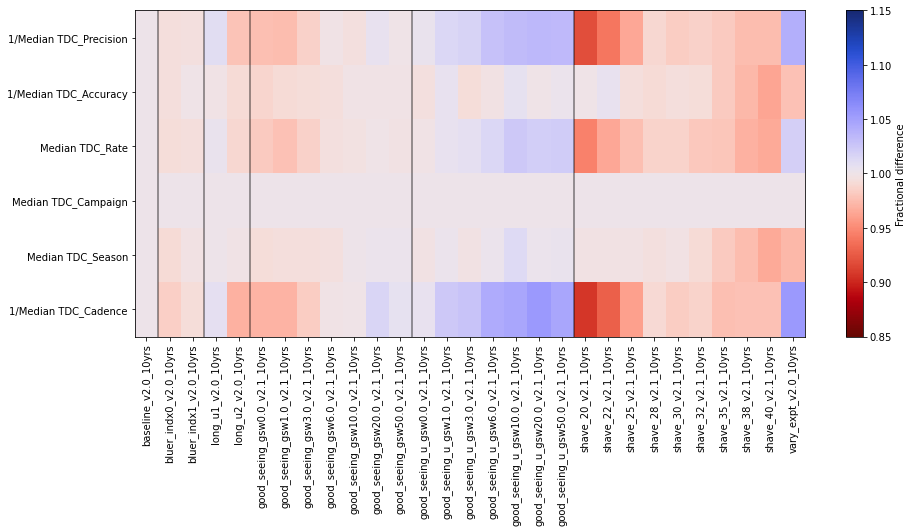

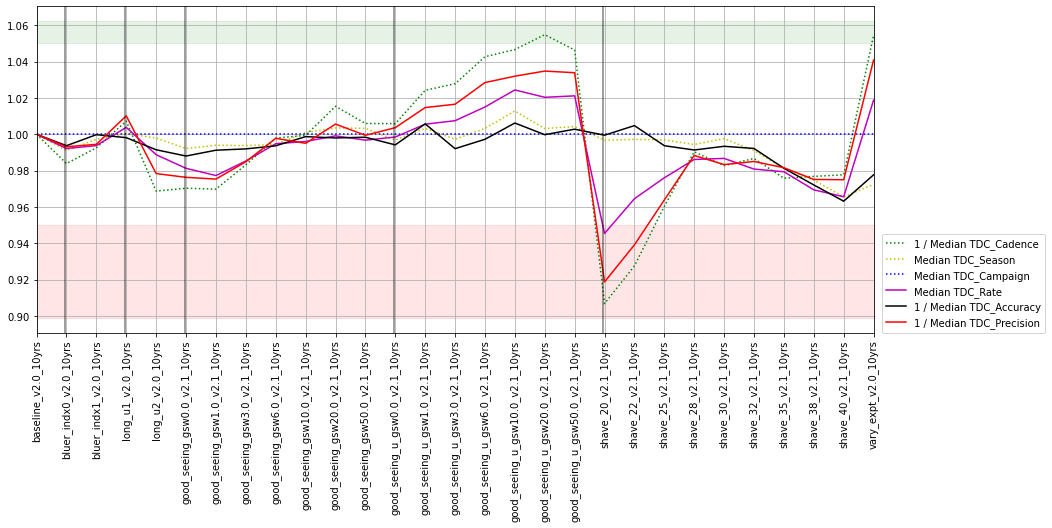

In [18]:
kk = ['SL TDC']
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

The time delay challenge metrics look at cadence, primarily (after visits meet a minimal depth cutoff). The shifts here are small, as would be expected. The changes with good seeing most likely reflect some unintended cadence shifting that occurs due to adding good seeing requirements.

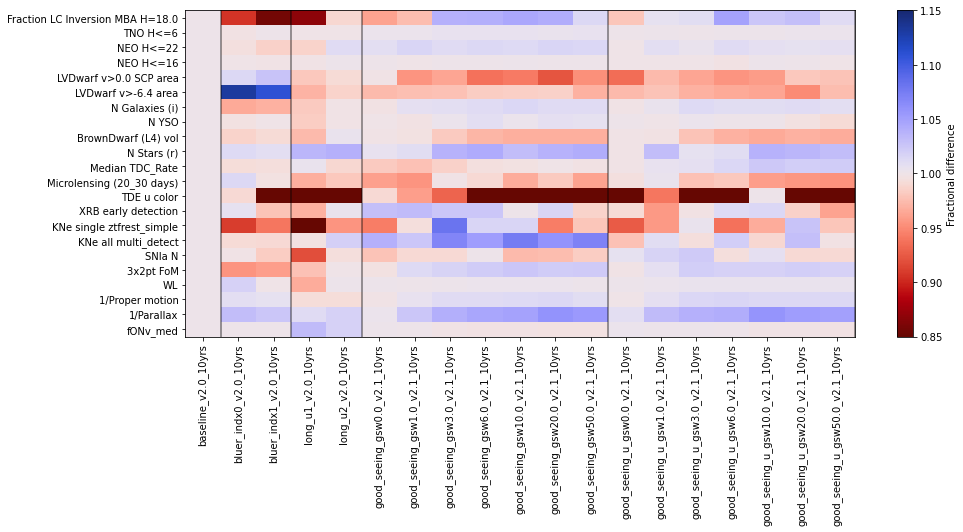

In [19]:
kk = ['SCOC']   # These are an attempt to capture most of the highest highest level metrics from above

tt = [r for r in these_runs if not r.startswith('shave') and not r.startswith('vary')]
for k in kk:

    fig, ax = maf.plot_run_metric_mesh(summaries.loc[tt, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)


The contents here are the metrics that seem both most important from previous documents from the collaborations or that have been the focus of recent discussions where they were indicated as important. I put them together here to see if they could help serve as a snapshot. 

Basically, my impression from these is that there is no compelling reason to shift away from the current filter balance in these metrics, and several that would be noticeably hurt by moving time into u/g bands. Photo-z determination is not included, and some specific metrics which may target the science areas which were highlighted as the reasons to move into bluer bands are not available (such as metrics for turnoff stars or star forming galaxies). It is worth noting that adding 'good seeing' requirements does have the added implication of shifting the timing and overall depth between bandpasses, although it will have other upsides that are not captured in metrics such as improved de-blending or star-galaxy separation. 